# **Loading the data**

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder


In [2]:
# Load the cleaned dataset
joined_df = pd.read_csv('joined_df.csv', index_col='respondent_id')
print("joined_df.shape", joined_df.shape)
joined_df.head()


joined_df.shape (26707, 35)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0,0


In [25]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA

In [26]:
# Separate features and target
target_cols = ['h1n1_vaccine', 'seasonal_vaccine']
X = joined_df.drop(columns=target_cols)
y = joined_df[target_cols]


In [29]:
# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns



In [30]:
# Encode categorical features

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Use sparse_output instead of sparse
encoded_cats = pd.DataFrame(encoder.fit_transform(X[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))
X = pd.concat([X.drop(columns=categorical_cols).reset_index(drop=True), encoded_cats.reset_index(drop=True)], axis=1)

In [31]:
# Standardize numeric features
scaler = StandardScaler()
scaled_numeric = pd.DataFrame(scaler.fit_transform(X[numeric_cols]), columns=numeric_cols)


In [32]:
# Combine the scaled numeric and encoded categorical features
X_processed = pd.concat([scaled_numeric.reset_index(drop=True), encoded_cats.reset_index(drop=True)], axis=1)

In [33]:
# # Apply PCA
# pca = PCA(n_components=0.95)  # Retain 95% of variance
# X_pca = pca.fit_transform(X_processed)

# # Display the explained variance ratio
# print(f"Explained Variance Ratio by PCA Components:\n{pca.explained_variance_ratio_}")
# print(f"Total Number of PCA Components Retained: {pca.n_components_}")

Explained Variance Ratio by PCA Components:
[0.12544481 0.06544071 0.05766628 0.05259455 0.04666716 0.04021209
 0.03796003 0.03449745 0.0331635  0.03136774 0.03040613 0.02908698
 0.028162   0.02770443 0.02552443 0.02329712 0.0223207  0.02087464
 0.01989963 0.01736881 0.01664858 0.01594797 0.01434029 0.01368625
 0.01339096 0.01277959 0.01241226 0.0121345  0.01096596 0.00922688
 0.00879896 0.00821698 0.00722049 0.00695827 0.00619954 0.00558659
 0.00515798 0.00504836]
Total Number of PCA Components Retained: 38


In [44]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)


In [45]:
# Build a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [46]:
# Make predictions
y_pred = rf_model.predict(X_val)


In [47]:
# Evaluate model
print("H1N1 Vaccine Classification Report:")
print(classification_report(y_val['h1n1_vaccine'], y_pred[:, 0]))
print("\nSeasonal Vaccine Classification Report:")
print(classification_report(y_val['seasonal_vaccine'], y_pred[:, 1]))


H1N1 Vaccine Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4212
           1       0.72      0.37      0.49      1130

    accuracy                           0.84      5342
   macro avg       0.78      0.67      0.69      5342
weighted avg       0.82      0.84      0.81      5342


Seasonal Vaccine Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2891
           1       0.77      0.75      0.76      2451

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



In [48]:
# Check feature importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False).head(10))

opinion_seas_risk              0.073336
opinion_seas_vacc_effective    0.061035
doctor_recc_seasonal           0.056344
doctor_recc_h1n1               0.051334
opinion_h1n1_risk              0.044856
opinion_h1n1_vacc_effective    0.041578
opinion_h1n1_sick_from_vacc    0.029716
opinion_seas_sick_from_vacc    0.029350
h1n1_concern                   0.029111
household_adults               0.023166
dtype: float64


In [49]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for ROC
y_proba = rf_model.predict_proba(X_val)

# Separate probabilities for each label
y_proba_h1n1 = y_proba[0][:, 1]  # Probabilities for class 1 of 'h1n1_vaccine'
y_proba_seasonal = y_proba[1][:, 1]  # Probabilities for class 1 of 'seasonal_vaccine'


In [50]:
# Compute ROC curve and AUC for 'h1n1_vaccine'
fpr_h1n1, tpr_h1n1, _ = roc_curve(y_val['h1n1_vaccine'], y_proba_h1n1)
roc_auc_h1n1 = auc(fpr_h1n1, tpr_h1n1)

# Compute ROC curve and AUC for 'seasonal_vaccine'
fpr_seasonal, tpr_seasonal, _ = roc_curve(y_val['seasonal_vaccine'], y_proba_seasonal)
roc_auc_seasonal = auc(fpr_seasonal, tpr_seasonal)



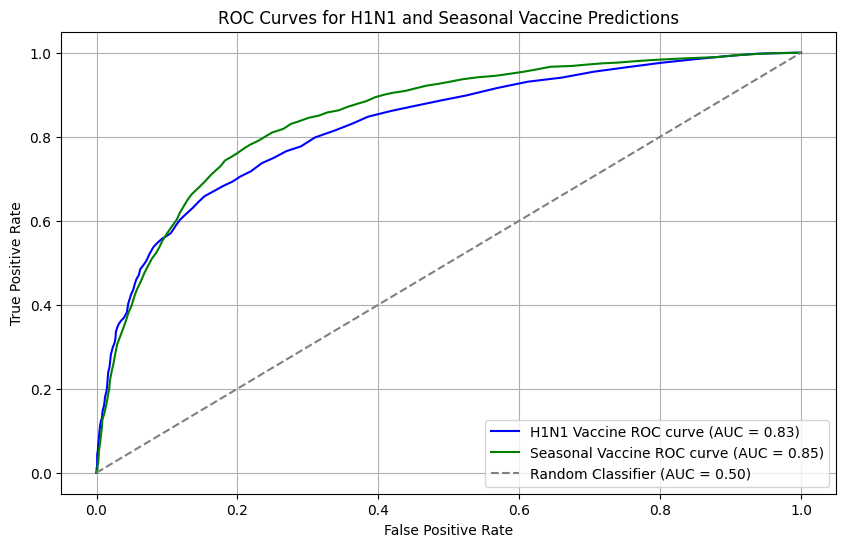

In [52]:
import matplotlib.pyplot as plt

# Plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_h1n1, tpr_h1n1, color='blue', label=f'H1N1 Vaccine ROC curve (AUC = {roc_auc_h1n1:.2f})')
plt.plot(fpr_seasonal, tpr_seasonal, color='green', label=f'Seasonal Vaccine ROC curve (AUC = {roc_auc_seasonal:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for H1N1 and Seasonal Vaccine Predictions')
plt.legend(loc="lower right")
plt.grid()
plt.show()